In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Download dataset

In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1cnZYxw-icztjt3bF48bpHoduUd-iA_n_

Downloading...
From: https://drive.google.com/uc?id=1cnZYxw-icztjt3bF48bpHoduUd-iA_n_
To: /content/heart.csv
100% 38.1k/38.1k [00:00<00:00, 61.2MB/s]


In [ ]:
df = pd.read_csv('/content/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [ ]:
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
categorical_one_hot = encoder.fit_transform(df[categorical_columns])
categorical_one_hot = pd.DataFrame(categorical_one_hot.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

df_preprocessed = pd.concat([df[numerical_columns], categorical_one_hot], axis=1)
df_preprocessed.head()

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,52,125,212,168,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,53,140,203,155,3.1,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,70,145,174,125,2.6,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,61,148,203,161,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,62,138,294,106,1.9,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
X = df_preprocessed.to_numpy()
y = df['target'].to_numpy()

print(X.shape)
print(y.shape)

(1025, 30)
(1025,)


Standard normal distribution

In [ ]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

X_preprocessed = (X - X_mean) / X_std

In [ ]:
y_reshape = y.reshape(y.shape[0], 1)
y_one_hot = encoder.fit_transform(y_reshape).toarray()
print(y_one_hot)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [ ]:
split_point = 900
X_train = X_preprocessed[:split_point]
y_train = y_one_hot[:split_point]

X_test = X_preprocessed[split_point:]
y_test = y_one_hot[split_point:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 30)
(900, 2)
(125, 30)
(125, 2)


In [ ]:
class HeartDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = HeartDataset(X_train, y_train)
test_dataset = HeartDataset(X_test, y_test)

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = activation
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
class GLU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(GLU, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = activation

        self.fc_gate = nn.Linear(input_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()

        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x1 = self.fc1(x)
        x1 = self.activation(x1)

        gate = self.fc_gate(x)
        gate = self.sigmoid(gate)

        x2 = self.fc2(x1 * gate)
        x2 = self.softmax(x2)
        return x2

In [ ]:
import os
import sys

if not os.path.exists('/content/efficient-kan'):
    !git clone https://github.com/Blealtan/efficient-kan

if '/content/efficient-kan/src' not in sys.path:
    sys.path.append('/content/efficient-kan/src')

sys.path

Cloning into 'efficient-kan'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 84 (delta 19), reused 14 (delta 13), pack-reused 56
Receiving objects: 100% (84/84), 31.41 KiB | 190.00 KiB/s, done.
Resolving deltas: 100% (31/31), done.


['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/efficient-kan/src']

In [ ]:
from efficient_kan import KANLinear

### Create model

In [ ]:
MLP_model = MLP(30, 100, 2, nn.GELU()) # 3302 parameters
MLP_model.to(device)

MLP_optimizer = optim.AdamW(MLP_model.parameters(), lr=0.001, weight_decay=0.01)
MLP_criterion = nn.CrossEntropyLoss()

In [ ]:
GLU_model = GLU(30, 100, 2, nn.GELU()) # 6402 parameters
GLU_model.to(device)

GLU_optimizer = optim.AdamW(GLU_model.parameters(), lr=0.001, weight_decay=0.01)
GLU_criterion = nn.CrossEntropyLoss()

In [ ]:
KAN_model = KANLinear(30, 2) # 60 phi functions = 60 w + 60 SiLU + 60 B-spline
KAN_model.to(device)

KAN_optimizer = optim.AdamW(KAN_model.parameters(), lr=0.001, weight_decay=0.01)
KAN_criterion = nn.CrossEntropyLoss()

### Training

In [ ]:
def train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=10):
    train_loss_list = []
    test_loss_list = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)

        model.eval()
        test_loss = 0.0
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            test_loss += loss.item()

        test_loss /= len(test_loader)
        test_loss_list.append(test_loss)

        print(f'Epoch {epoch + 1}, Train loss: {train_loss}, Test loss: {test_loss}')

    return train_loss_list, test_loss_list

In [ ]:
MLP_train_loss_list, MLP_test_loss_list = train_model(MLP_model, MLP_optimizer, MLP_criterion, train_loader, test_loader, num_epochs=100)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1, Train loss: 0.6686701708369784, Test loss: 0.635198324918747
Epoch 2, Train loss: 0.6022651327980889, Test loss: 0.5804667174816132
Epoch 3, Train loss: 0.5508229467603896, Test loss: 0.541354775428772
Epoch 4, Train loss: 0.5138035549057854, Test loss: 0.5158278048038483
Epoch 5, Train loss: 0.48963482512368095, Test loss: 0.5001571029424667
Epoch 6, Train loss: 0.47263020608160233, Test loss: 0.49139203131198883
Epoch 7, Train loss: 0.46128160423702663, Test loss: 0.48612986505031586
Epoch 8, Train loss: 0.45320676763852435, Test loss: 0.4823014736175537
Epoch 9, Train loss: 0.44712093141343856, Test loss: 0.4793987274169922
Epoch 10, Train loss: 0.44235196709632874, Test loss: 0.4773769825696945
Epoch 11, Train loss: 0.4377104341983795, Test loss: 0.47479480504989624
Epoch 12, Train loss: 0.4338201714886559, Test loss: 0.47257576882839203
Epoch 13, Train loss: 0.42993173334333634, Test loss: 0.47004133462905884
Epoch 14, Train loss: 0.42663593424691093, Test loss: 0.4677150

In [ ]:
GLU_train_loss_list, GLU_test_loss_list = train_model(GLU_model, GLU_optimizer, GLU_criterion, train_loader, test_loader, num_epochs=100)

Epoch 1, Train loss: 0.6754731668366326, Test loss: 0.6523183584213257
Epoch 2, Train loss: 0.6311644315719604, Test loss: 0.612286239862442
Epoch 3, Train loss: 0.5885845422744751, Test loss: 0.5738986432552338
Epoch 4, Train loss: 0.5481438438097636, Test loss: 0.5408677160739899
Epoch 5, Train loss: 0.5151851442125108, Test loss: 0.5167348682880402
Epoch 6, Train loss: 0.4907987084653642, Test loss: 0.5011672079563141
Epoch 7, Train loss: 0.47421815660264754, Test loss: 0.49161821603775024
Epoch 8, Train loss: 0.46225272284613717, Test loss: 0.48587408661842346
Epoch 9, Train loss: 0.4533526764975654, Test loss: 0.4815533459186554
Epoch 10, Train loss: 0.44662367635303074, Test loss: 0.4782654792070389
Epoch 11, Train loss: 0.440750883685218, Test loss: 0.4754648655653
Epoch 12, Train loss: 0.43586966064241195, Test loss: 0.47304362058639526
Epoch 13, Train loss: 0.4311071534951528, Test loss: 0.4702078104019165
Epoch 14, Train loss: 0.42697565091980827, Test loss: 0.466816321015357

In [ ]:
KAN_train_loss_list, KAN_test_loss_list = train_model(KAN_model, KAN_optimizer, KAN_criterion, train_loader, test_loader, num_epochs=100)

Epoch 1, Train loss: 0.7452902131610446, Test loss: 0.7426479160785675
Epoch 2, Train loss: 0.7021232909626431, Test loss: 0.7010054588317871
Epoch 3, Train loss: 0.6620489226447211, Test loss: 0.6629336178302765
Epoch 4, Train loss: 0.6242643462287055, Test loss: 0.6285732686519623
Epoch 5, Train loss: 0.589800602859921, Test loss: 0.5967486798763275
Epoch 6, Train loss: 0.5581273999479082, Test loss: 0.5678685009479523
Epoch 7, Train loss: 0.5298751129044427, Test loss: 0.5423609614372253
Epoch 8, Train loss: 0.5045364830229018, Test loss: 0.5198137164115906
Epoch 9, Train loss: 0.482013119591607, Test loss: 0.5001505762338638
Epoch 10, Train loss: 0.461805048916075, Test loss: 0.48268941044807434
Epoch 11, Train loss: 0.44480416509840226, Test loss: 0.46749715507030487
Epoch 12, Train loss: 0.42903658085399204, Test loss: 0.45400160551071167
Epoch 13, Train loss: 0.4151887794335683, Test loss: 0.4419342577457428
Epoch 14, Train loss: 0.4028039773305257, Test loss: 0.4318396151065826

### Visualization

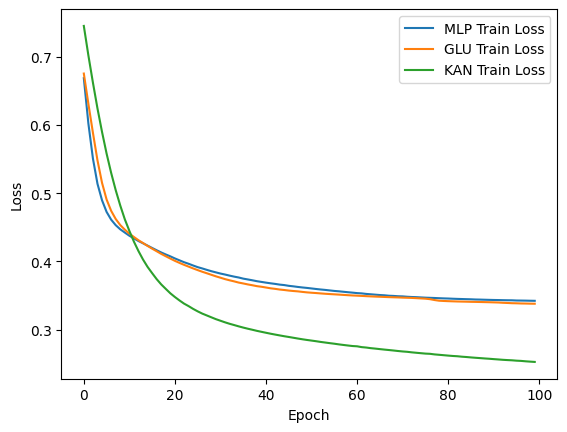

In [ ]:
import matplotlib.pyplot as plt

plt.plot(MLP_train_loss_list, label='MLP Train Loss')
plt.plot(GLU_train_loss_list, label='GLU Train Loss')
plt.plot(KAN_train_loss_list, label='KAN Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

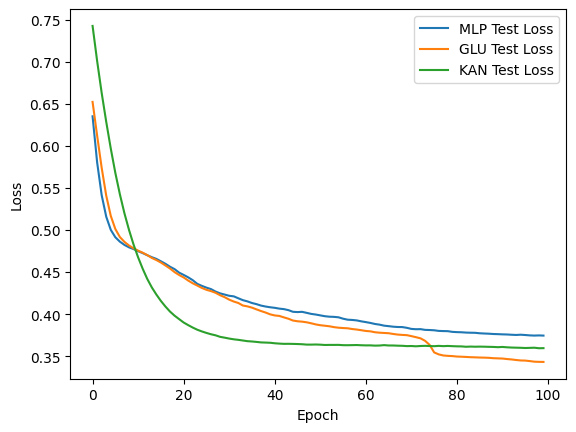

In [ ]:
plt.plot(MLP_test_loss_list, label='MLP Test Loss')
plt.plot(GLU_test_loss_list, label='GLU Test Loss')
plt.plot(KAN_test_loss_list, label='KAN Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, test_loader):
    model.eval()

    y_true = []
    y_pred = []

    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred_batch = model(X_batch)
        y_pred_batch = torch.argmax(y_pred_batch, dim=1)
        y_true_batch = torch.argmax(y_batch, dim=1)

        y_true.extend(y_true_batch.cpu().numpy())
        y_pred.extend(y_pred_batch.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return cm, acc, precision, recall, f1

In [ ]:
cm, acc, precision, recall, f1 = evaluate_model(MLP_model, test_loader)
print(f'Confusion Matrix:\n{cm}')
print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Confusion Matrix:
[[61  2]
 [ 6 56]]
Accuracy: 0.936
Precision: 0.9655172413793104
Recall: 0.9032258064516129
F1 Score: 0.9333333333333333


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
cm, acc, precision, recall, f1 = evaluate_model(GLU_model, test_loader)
print(f'Confusion Matrix:\n{cm}')
print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Confusion Matrix:
[[61  2]
 [ 3 59]]
Accuracy: 0.96
Precision: 0.9672131147540983
Recall: 0.9516129032258065
F1 Score: 0.959349593495935


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
cm, acc, precision, recall, f1 = evaluate_model(KAN_model, test_loader)
print(f'Confusion Matrix:\n{cm}')
print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Confusion Matrix:
[[55  8]
 [ 9 53]]
Accuracy: 0.864
Precision: 0.8688524590163934
Recall: 0.8548387096774194
F1 Score: 0.8617886178861789


### Save weights

In [ ]:
MLP_weight_path = '/content/MLP_weights.pt'
GLU_weight_path = '/content/GLU_weights.pt'

torch.save(MLP_model.state_dict(), MLP_weight_path)
torch.save(GLU_model.state_dict(), GLU_weight_path)

In [ ]:
example_model = MLP(30, 100, 2, nn.GELU())
example_model.load_state_dict(torch.load(MLP_weight_path))
print(example_model)

MLP(
  (fc1): Linear(in_features=30, out_features=100, bias=True)
  (activation): GELU(approximate='none')
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (softmax): Softmax(dim=None)
)
